# ACIS Insurance Risk – Exploratory Data Analysis (EDA)

This notebook explores historical car insurance data for **AlphaCare Insurance Solutions (ACIS)**.

## Objectives

The goal of this EDA is to:

- Understand the structure and quality of the dataset.
- Compute core insurance KPIs, especially **Loss Ratio** and **Margin**.
- Explore how risk and profitability vary across:
  - Geography (Province, Postal Code)
  - Vehicle segments (VehicleType, Make)
  - Customer segments (Gender, LegalType, etc.)
  - Time (TransactionMonth)
- Identify potential **low-risk segments** that could justify **premium reductions** as part of ACIS’s marketing and pricing strategy.

The insights here will feed into:

- **A/B hypothesis testing** (Task 3)
- **Statistical & ML modeling** for premium optimization (Task 4).


In [21]:
"""
ACIS Insurance Risk – Exploratory Data Analysis (EDA)

This script/notebook walks through:
1. Data loading and basic structure checks
2. Type conversions (dates, categoricals)
3. Data quality & missing values
4. Business KPIs (Loss Ratio, Margin)
5. Segment analysis (Province, VehicleType, Gender, Make)
6. Distributions & outliers of key financial variables
7. Temporal trends over the 18-month window
8. Example of a "creative" plot (heatmap of LossRatio by VehicleType & Gender)
"""

# =========================
# 0. Imports & basic setup
# =========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display all columns in outputs (helpful in notebooks)
pd.set_option("display.max_columns", None)

# Optional: set a simple default plotting style
plt.style.use("default")



## 1. Data Loading

We first load the ACIS insurance dataset from local storage.  

Key points:

- The dataset is pipe `|` delimited (as provided in the technical material).
- Each row represents an underwritten cover for a motor policy.
- The main outcome variables of interest are:
  - `TotalPremium` – the total premium collected.
  - `TotalClaims` – the total claim amount incurred.

After loading, we inspect the head of the dataset and its overall shape to confirm that the file was read correctly.


In [22]:
# ==================================
# 1. Load the data from local storage
# ==================================

# Adjust the path and delimiter if needed
DATA_PATH = "../data/raw/MachineLearningRating_v3.txt"  # or your actual filename

# This dataset appears pipe '|' delimited from the materials
df = pd.read_csv(DATA_PATH, sep="|")

print("Data loaded.")
print("Shape:", df.shape)
print("\nHead:")
print(df.head())


C:\Users\Dawit\AppData\Local\Temp\ipykernel_21544\4211878683.py:9: DtypeWarning: Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH, sep="|")


Data loaded.
Shape: (1000098, 52)

Head:
   UnderwrittenCoverID  PolicyID     TransactionMonth  IsVATRegistered  \
0               145249     12827  2015-03-01 00:00:00             True   
1               145249     12827  2015-05-01 00:00:00             True   
2               145249     12827  2015-07-01 00:00:00             True   
3               145255     12827  2015-05-01 00:00:00             True   
4               145255     12827  2015-07-01 00:00:00             True   

  Citizenship          LegalType Title Language                 Bank  \
0              Close Corporation    Mr  English  First National Bank   
1              Close Corporation    Mr  English  First National Bank   
2              Close Corporation    Mr  English  First National Bank   
3              Close Corporation    Mr  English  First National Bank   
4              Close Corporation    Mr  English  First National Bank   

       AccountType  MaritalStatus         Gender       Country Province  \
0  Cur

## 2. Initial Overview & Data Structure

Here we:

- Inspect the **data types** of each column using `df.info()`.
- Review summary statistics for both numeric and categorical variables using `df.describe(include="all")`.

**Early observations (update after inspecting output):**

- The dataset contains approximately **1,000,000+ rows**, indicating a large portfolio.
- `Language`, `Country`, `StatutoryClass`, and `StatutoryRiskType` are effectively **constant**, and thus not informative for modeling.
- Many fields are naturally **categorical** (e.g., `Province`, `VehicleType`, `Gender`, `make`, `Model`, `NewVehicle`, `CoverGroup`), while key financial fields (`TotalPremium`, `TotalClaims`, `SumInsured`, etc.) are numeric.

This step helps us decide which columns need type conversion (e.g., dates, categoricals) and which features are likely to be useful for later analysis.


In [23]:
# =====================================
# 2. Initial overview & data type check
# =====================================

print("\nData types:")
print(df.dtypes)

print("\nDescriptive statistics (numeric + categorical):")
print(df.describe(include="all").T)


Data types:
UnderwrittenCoverID           int64
PolicyID                      int64
TransactionMonth             object
IsVATRegistered                bool
Citizenship                  object
LegalType                    object
Title                        object
Language                     object
Bank                         object
AccountType                  object
MaritalStatus                object
Gender                       object
Country                      object
Province                     object
PostalCode                    int64
MainCrestaZone               object
SubCrestaZone                object
ItemType                     object
mmcode                      float64
VehicleType                  object
RegistrationYear              int64
make                         object
Model                        object
Cylinders                   float64
cubiccapacity               float64
kilowatts                   float64
bodytype                     object
NumberOfDoors  

## 3. Type Conversions & Data Quality

### 3.1 Type Conversions

We perform basic type fixes:

- Convert `TransactionMonth` to a proper **datetime** type.
- Cast key fields such as `Province`, `VehicleType`, `Gender`, `make`, `Model`, `CoverGroup`, etc., to **categorical** type.
- Treat `PostalCode` as a label (nullable integer), since it represents an area, not a continuous numeric measure.

These conversions:

- Make grouping and aggregation more efficient.
- Avoid incorrect numeric operations on label-like fields.

### 3.2 Missing Values

We then calculate the **fraction of missing values** per column.

Key notes (update with your observations):

- Some financial fields (e.g., `CustomValueEstimate`, `CapitalOutstanding`) have substantial missingness and may need special handling or exclusion from certain models.
- Demographic fields like `Gender` and `MaritalStatus` include large proportions of `"Not specified"`, which limits the strength of conclusions about these attributes.

At this stage we **do not** impute or drop columns; the goal is to understand data quality and document potential issues for modeling and hypothesis testing.


In [24]:
# ======================================
# 3. Type conversions & basic cleaning
# ======================================

# 3.1 Convert TransactionMonth to datetime
# ---------------------------------------
# TransactionMonth appears as a month-level date (e.g., '2015-08-01')
# errors='coerce' will turn invalid values into NaT (missing)
df["TransactionMonth"] = pd.to_datetime(df["TransactionMonth"], errors="coerce")


# 3.2 Treat selected columns as categoricals
# -----------------------------------------
# Based on your describe(), these are naturally categorical fields
cat_cols = [
    "IsVATRegistered", "Citizenship", "LegalType", "Title", "Language", "Bank",
    "AccountType", "MaritalStatus", "Gender", "Country", "Province",
    "MainCrestaZone", "SubCrestaZone", "ItemType", "VehicleType",
    "make", "Model", "bodytype", "NewVehicle", "WrittenOff", "Rebuilt",
    "Converted", "CrossBorder", "TermFrequency", "ExcessSelected",
    "CoverCategory", "CoverType", "CoverGroup", "Section", "Product",
    "StatutoryClass", "StatutoryRiskType", "AlarmImmobiliser", "TrackingDevice"
]

for c in cat_cols:
    if c in df.columns:
        df[c] = df[c].astype("category")

# 3.3 PostalCode: treat as integer or string (for grouping)
# --------------------------------------------------------
# It’s numeric but conceptually a category / label
if "PostalCode" in df.columns:
    # Use nullable integer type so missing values are allowed
    df["PostalCode"] = df["PostalCode"].astype("Int64")

print("\nInfo after type conversions:")
print(df.info())


Info after type conversions:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000098 entries, 0 to 1000097
Data columns (total 52 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   UnderwrittenCoverID       1000098 non-null  int64         
 1   PolicyID                  1000098 non-null  int64         
 2   TransactionMonth          1000098 non-null  datetime64[ns]
 3   IsVATRegistered           1000098 non-null  category      
 4   Citizenship               1000098 non-null  category      
 5   LegalType                 1000098 non-null  category      
 6   Title                     1000098 non-null  category      
 7   Language                  1000098 non-null  category      
 8   Bank                      854137 non-null   category      
 9   AccountType               959866 non-null   category      
 10  MaritalStatus             991839 non-null   category      
 11  Gender              

## 4. Core Business Metrics: Loss Ratio & Margin

In insurance analytics, two key metrics are:

- **Loss Ratio** = `TotalClaims / TotalPremium`  
  - Measures how much is paid out in claims for each unit of premium.
  - A loss ratio **below 1** indicates profitable business (claims < premiums).
  - A loss ratio **above 1** indicates unprofitable business (claims > premiums).

- **Margin** = `TotalPremium - TotalClaims`  
  - Measures the absolute profit (or loss) per record.

To avoid division by zero and non-sense ratios, we:

- Restrict the Loss Ratio calculation to records where **`TotalPremium > 0`**.

The overall portfolio loss ratio is computed as the mean of per-record loss ratios.  
We will use this as a benchmark when evaluating different segments (geography, vehicles, gender, etc.).


In [25]:
# ======================================
# 4. Data quality & missing values check
# ======================================

# Fraction of missing values per column
missing_fraction = df.isna().mean().sort_values(ascending=False)
print("\nTop 20 columns by missing fraction:")
print(missing_fraction.head(20))


Top 20 columns by missing fraction:
NumberOfVehiclesInFleet    1.000000
CrossBorder                0.999302
CustomValueEstimate        0.779566
Rebuilt                    0.641838
Converted                  0.641838
WrittenOff                 0.641838
NewVehicle                 0.153280
Bank                       0.145947
AccountType                0.040228
Gender                     0.009535
MaritalStatus              0.008258
VehicleType                0.000552
make                       0.000552
mmcode                     0.000552
Model                      0.000552
Cylinders                  0.000552
bodytype                   0.000552
kilowatts                  0.000552
NumberOfDoors              0.000552
VehicleIntroDate           0.000552
dtype: float64


## 5. Segment-Level Risk Analysis

To understand how risk varies across different dimensions, we create a helper function that:

- Groups data by one or more categorical variables.
- Aggregates `TotalPremium` and `TotalClaims`.
- Computes **Loss Ratio** and **Margin** for each segment.

This allows us to consistently compare segments such as:

- Provinces
- Vehicle types
- Genders
- Vehicle makes

against the **overall portfolio**.


In [26]:
# ===============================================
# 5. Create key business metrics: LossRatio, Margin
# ===============================================

# LossRatio = TotalClaims / TotalPremium
# Margin   = TotalPremium - TotalClaims
# IMPORTANT:
# - We restrict LossRatio calculation to rows with TotalPremium > 0
#   to avoid division by zero or non-sense ratios for zero/negative premiums.

# Make a copy for loss ratio analysis
df_lr = df.copy()

# Filter for positive premium
df_lr = df_lr[df_lr["TotalPremium"] > 0]

# Create metrics
df_lr["LossRatio"] = df_lr["TotalClaims"] / df_lr["TotalPremium"]
df_lr["Margin"] = df_lr["TotalPremium"] - df_lr["TotalClaims"]

print("\nLossRatio summary (only rows with TotalPremium > 0):")
print(df_lr["LossRatio"].describe())

# Overall portfolio Loss Ratio (simple mean of per-record ratios)
overall_lr = df_lr["LossRatio"].mean()
print("\nOverall portfolio Loss Ratio:", overall_lr)


LossRatio summary (only rows with TotalPremium > 0):
count    618176.000000
mean          0.350048
std           9.288639
min         -18.700122
25%           0.000000
50%           0.000000
75%           0.000000
max        2553.600000
Name: LossRatio, dtype: float64

Overall portfolio Loss Ratio: 0.3500476647582784


### 5.1 Loss Ratio by Province

Here we aggregate premiums and claims by `Province` and compute:

- Total premium volume per province.
- Total claims per province.
- Loss Ratio and Margin for each province.

The bar plot shows the **Loss Ratio by Province**, sorted from lowest (safest) to highest (riskiest).

**Insights (update after viewing results):**

- Some provinces , have **loss ratios well below the portfolio average**, indicating more profitable / lower-risk business.
- Others , show **elevated loss ratios**, suggesting higher risk or pricing/underwriting issues.
- Provinces with both **large premium volume** and **low loss ratios** are strong candidates for:
  - Targeted marketing campaigns.
  - Potentially reduced premiums to attract more similar customers.


In [27]:
# ====================================================
# 6. Helper function to summarise LossRatio by segment
# ====================================================

def summarize_loss_ratio(df_in: pd.DataFrame, group_cols):
    """
    Summarise TotalPremium, TotalClaims, LossRatio and Margin
    for the given grouping columns.

    Parameters
    ----------
    df_in : pd.DataFrame
        DataFrame that already has 'TotalPremium' and 'TotalClaims'.
    group_cols : list or str
        Column name(s) to group by.

    Returns
    -------
    pd.DataFrame
        Aggregated DataFrame sorted by LossRatio ascending.
    """
    agg = df_in.groupby(group_cols)[["TotalPremium", "TotalClaims"]].sum()
    agg["LossRatio"] = agg["TotalClaims"] / agg["TotalPremium"]
    agg["Margin"] = agg["TotalPremium"] - agg["TotalClaims"]
    return agg.sort_values("LossRatio")

### 5.2 Loss Ratio by Vehicle Type

We repeat the same analysis for `VehicleType`, aggregating across all time and geography.

**Key observations:**

- Certain vehicle types (e.g., *Passenger Vehicle, Light commercial vehicle, etc.*) dominate the portfolio.
- Some vehicle types exhibit **consistently lower loss ratios**, making them attractive segments for growth.
- Vehicle types with **high loss ratios** may warrant:
  - Stricter underwriting criteria,
  - Higher premiums,
  - Or further investigation into claim drivers.

This breakdown helps us understand how the nature of the vehicle influences overall risk.



Loss Ratio by Province:
               TotalPremium   TotalClaims  LossRatio        Margin
Province                                                          
Northern Cape  3.165581e+05  8.949051e+04   0.282699  2.270676e+05
Free State     5.213632e+05  2.659749e+05   0.510153  2.553883e+05
Eastern Cape   2.140303e+06  1.346308e+06   0.629027  7.939949e+05
Limpopo        1.537324e+06  9.918930e+05   0.645207  5.454315e+05
Mpumalanga     2.836292e+06  2.035792e+06   0.717765  8.004995e+05
North West     7.490508e+06  5.593723e+06   0.746775  1.896786e+06
KwaZulu-Natal  1.323578e+07  1.352635e+07   1.021953 -2.905689e+05
Western Cape   9.810107e+06  1.024226e+07   1.044052 -4.321559e+05
Gauteng        2.405487e+07  2.798127e+07   1.163227 -3.926403e+06


C:\Users\Dawit\AppData\Local\Temp\ipykernel_21544\2744580857.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = df_in.groupby(group_cols)[["TotalPremium", "TotalClaims"]].sum()


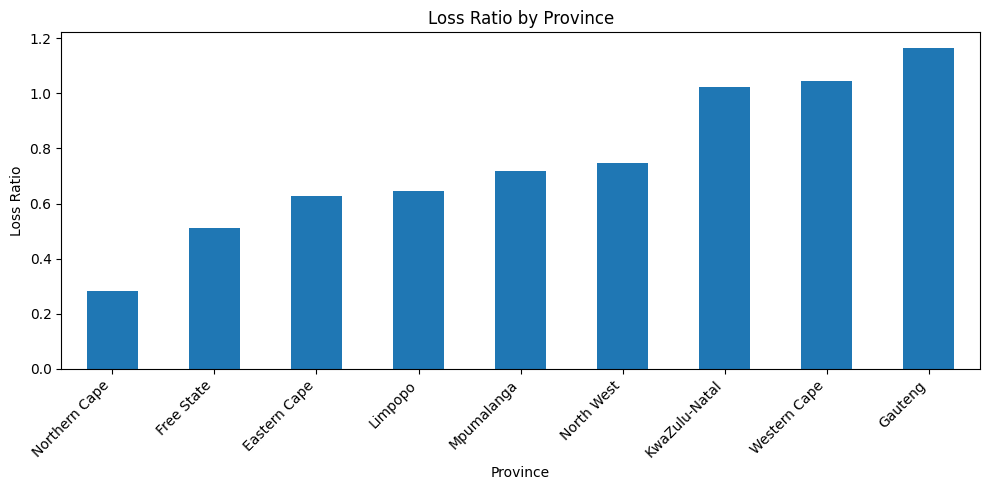

C:\Users\Dawit\AppData\Local\Temp\ipykernel_21544\2744580857.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = df_in.groupby(group_cols)[["TotalPremium", "TotalClaims"]].sum()



Loss Ratio by Vehicle Type:
                   TotalPremium   TotalClaims  LossRatio         Margin
VehicleType                                                            
Bus                5.824474e+04  0.000000e+00   0.000000   58244.739658
Light Commercial   2.604975e+05  6.045250e+04   0.232066  200045.020424
Passenger Vehicle  5.667341e+07  5.668048e+07   1.000125   -7071.954993
Medium Commercial  3.922840e+06  4.032212e+06   1.027881 -109372.483407
Heavy Commercial   4.609479e+05  7.432425e+05   1.612422 -282294.654598


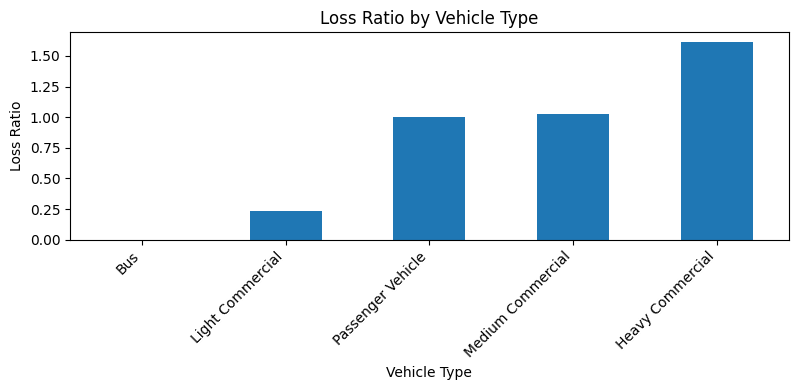

C:\Users\Dawit\AppData\Local\Temp\ipykernel_21544\2744580857.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = df_in.groupby(group_cols)[["TotalPremium", "TotalClaims"]].sum()



Loss Ratio by Gender:
               TotalPremium   TotalClaims  LossRatio         Margin
Gender                                                             
Male           1.606618e+06  1.242916e+06   0.773623  363702.037990
Female         3.044806e+05  2.472774e+05   0.812129   57203.159732
Not specified  5.920782e+07  6.007638e+07   1.014670 -868559.731428


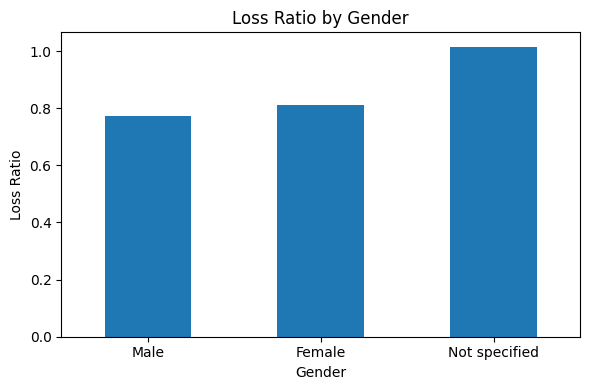

In [28]:
# =====================================================
# 7. Risk by Province, VehicleType, Gender (core EDA)
# =====================================================

# 7.1 Loss ratio by Province
if "Province" in df_lr.columns:
    lr_by_province = summarize_loss_ratio(df_lr, "Province")
    print("\nLoss Ratio by Province:")
    print(lr_by_province)

    # Bar plot – LossRatio by Province (sorted)
    plt.figure(figsize=(10, 5))
    plot_data = lr_by_province.sort_values("LossRatio")
    plot_data["LossRatio"].plot(kind="bar")
    plt.title("Loss Ratio by Province")
    plt.ylabel("Loss Ratio")
    plt.xlabel("Province")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


# 7.2 Loss ratio by VehicleType
if "VehicleType" in df_lr.columns:
    lr_by_vehicle = summarize_loss_ratio(df_lr, "VehicleType")
    print("\nLoss Ratio by Vehicle Type:")
    print(lr_by_vehicle)

    plt.figure(figsize=(8, 4))
    plot_data = lr_by_vehicle.sort_values("LossRatio")
    plot_data["LossRatio"].plot(kind="bar")
    plt.title("Loss Ratio by Vehicle Type")
    plt.ylabel("Loss Ratio")
    plt.xlabel("Vehicle Type")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


# 7.3 Loss ratio by Gender
if "Gender" in df_lr.columns:
    lr_by_gender = summarize_loss_ratio(df_lr, "Gender")
    print("\nLoss Ratio by Gender:")
    print(lr_by_gender)

    plt.figure(figsize=(6, 4))
    lr_by_gender["LossRatio"].plot(kind="bar")
    plt.title("Loss Ratio by Gender")
    plt.ylabel("Loss Ratio")
    plt.xlabel("Gender")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

## 6. Distributions & Outliers of Key Financial Variables

We explore the distribution of key numeric variables:

- `TotalPremium`
- `TotalClaims`
- `SumInsured`
- `CustomValueEstimate`
- `CalculatedPremiumPerTerm`
- `CapitalOutstanding`

### 6.1 Histograms

Histograms (and log-scale variants) reveal:

- Strong **right-skewness** in claims and premiums: most policies have small to moderate values, but a few policies have extremely high claims or premiums.
- `CustomValueEstimate` can take very large values relative to the median, hinting at potential outliers.

### 6.2 Boxplots

Boxplots make outliers clearly visible:

- There are many **extreme values** for `TotalClaims` and `SumInsured`.
- Negative values in `TotalPremium` and `TotalClaims` likely represent **refunds** or **adjustments**.

**Implications for modeling:**

- Consider using **robust statistics** (medians, percentiles) rather than relying only on means.
- For certain models, it may be useful to:
  - Apply log transformations (`log1p`) to highly skewed variables.
  - Cap or treat extreme outliers carefully to avoid instability.


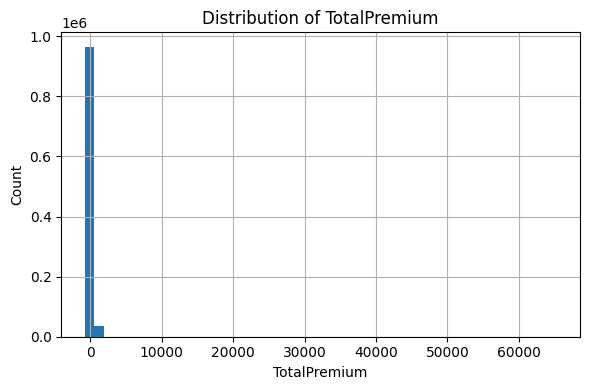

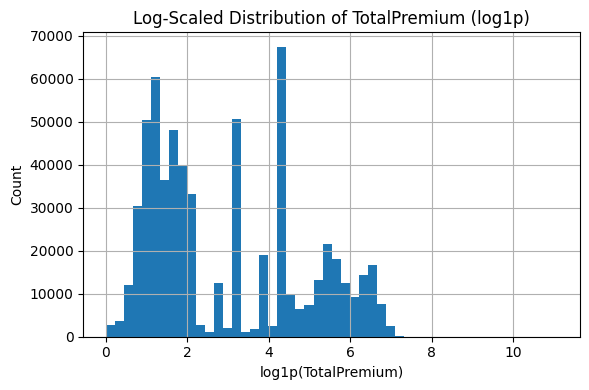

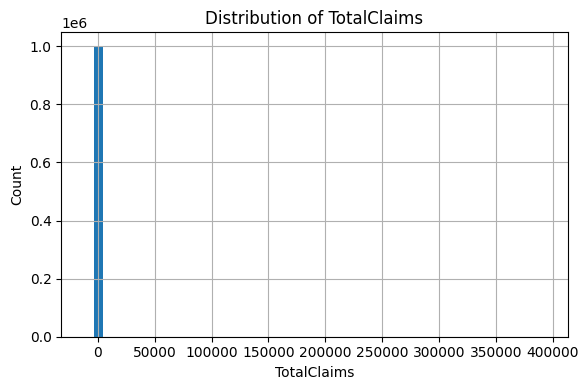

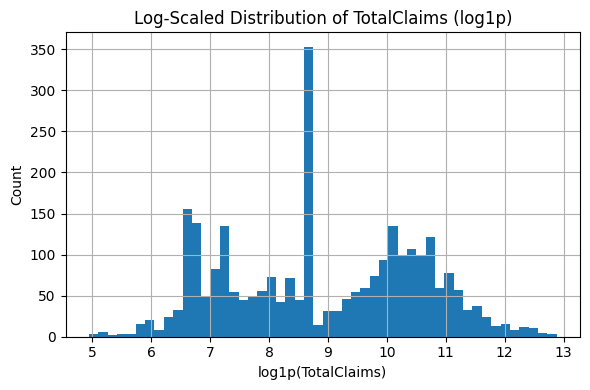

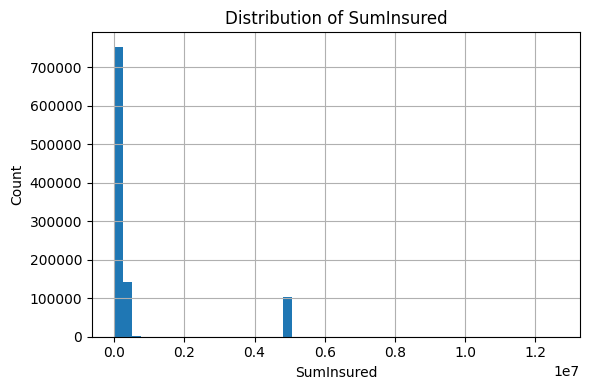

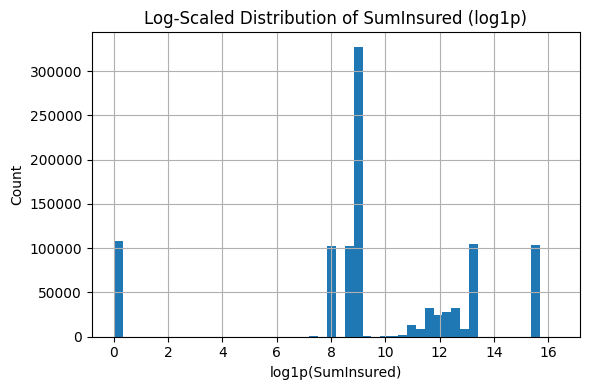

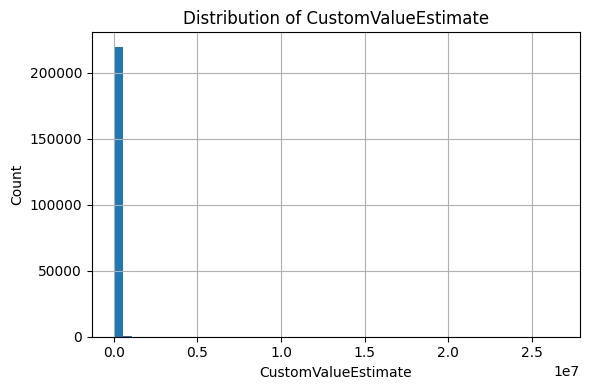

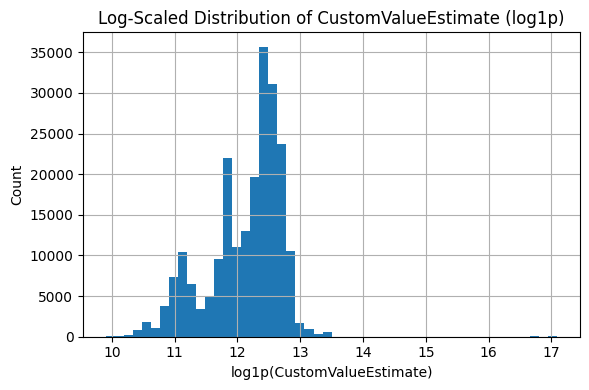

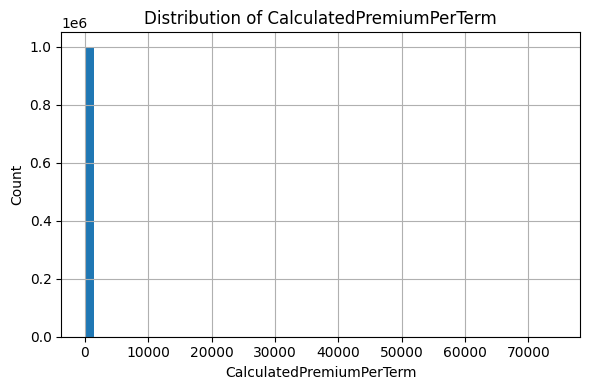

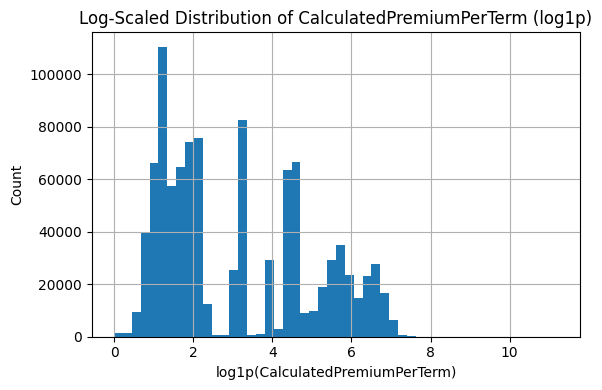

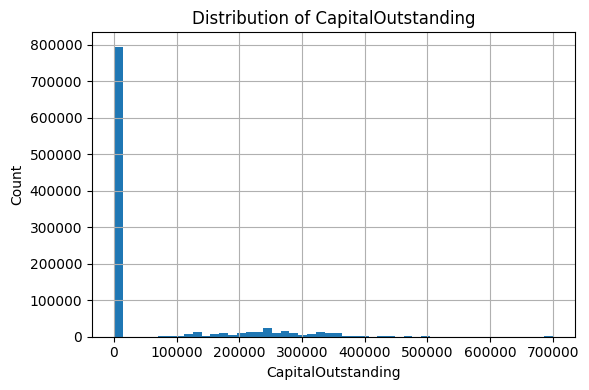

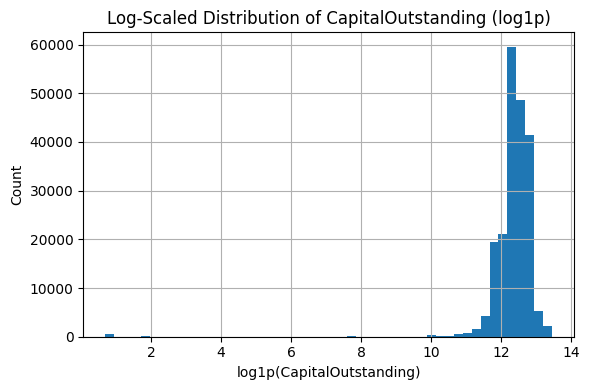

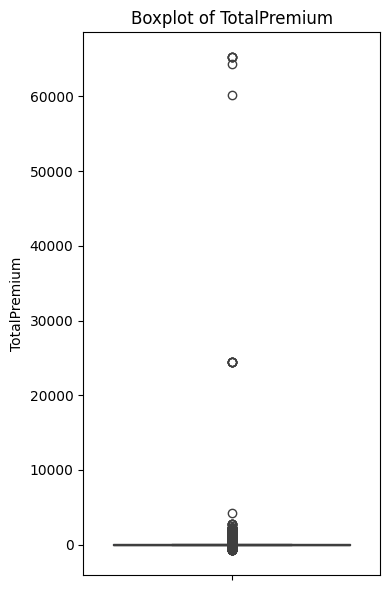

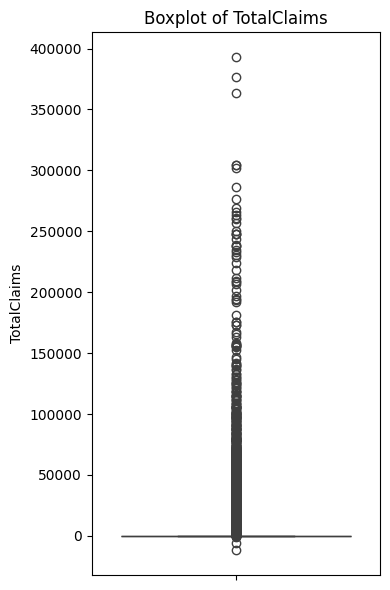

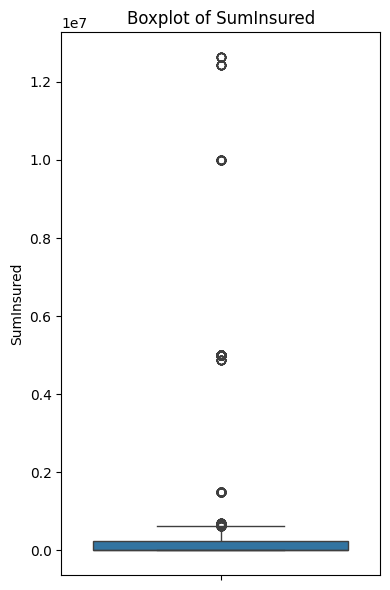

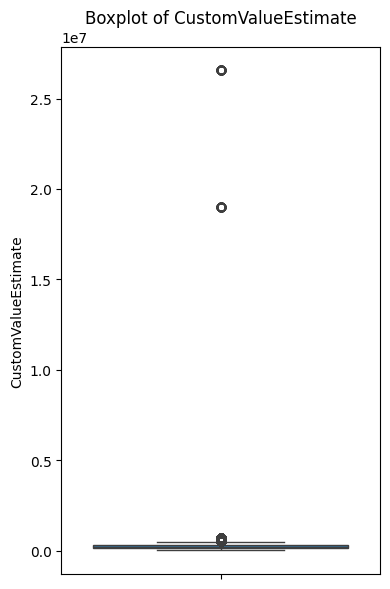

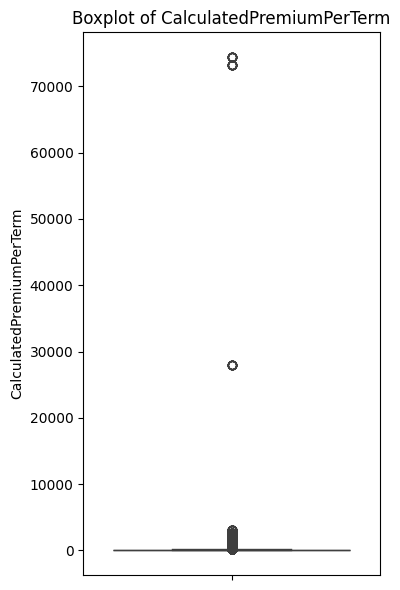

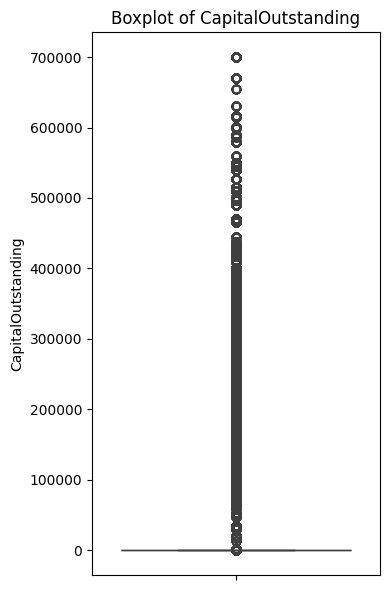

In [29]:
# ==========================================================
# 8. Distributions & outliers of key financial numeric fields
# ==========================================================

# Focus on variables that matter to the business & risk
num_cols = [
    "TotalPremium", "TotalClaims", "SumInsured",
    "CustomValueEstimate", "CalculatedPremiumPerTerm",
    "CapitalOutstanding"
]

# 8.1 Histograms to understand shape/skew
for col in num_cols:
    if col in df.columns:
        # Coerce to numeric in case there are strings or mixed types
        s = pd.to_numeric(df[col], errors="coerce")

        # Drop missing values after coercion
        s = s.dropna()

        # If column ends up empty, skip
        if s.empty:
            print(f"Skipping {col}: no valid numeric data after coercion.")
            continue

        plt.figure(figsize=(6, 4))
        s.hist(bins=50)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

        # Optional: log scale (only for positive values)
        if (s > 0).sum() > 0:
            plt.figure(figsize=(6, 4))
            np.log1p(s[s > 0]).hist(bins=50)
            plt.title(f"Log-Scaled Distribution of {col} (log1p)")
            plt.xlabel(f"log1p({col})")
            plt.ylabel("Count")
            plt.tight_layout()
            plt.show()


# 8.2 Boxplots for outlier detection
for col in num_cols:
    if col in df.columns:
        s = pd.to_numeric(df[col], errors="coerce").dropna()
        if s.empty:
            print(f"Skipping boxplot for {col}: no valid numeric data after coercion.")
            continue

        plt.figure(figsize=(4, 6))
        sns.boxplot(y=s)
        plt.title(f"Boxplot of {col}")
        plt.tight_layout()
        plt.show()

## 7. Temporal Trends (February 2014 – August 2015)

We aggregate the data by `TransactionMonth` to examine:

- Monthly **TotalPremium** and **TotalClaims**
- Monthly **Loss Ratio**

### 7.1 Monthly Loss Ratio

The line plot shows how the Loss Ratio evolves over time:

- We look for **trends** (e.g., improving or deteriorating risk over the 18-month period).
- We also identify any **spikes** in loss ratio that might correspond to:
  - Catastrophic events,
  - Pricing changes,
  - Portfolio mix changes.

### 7.2 Premium and Claims over Time

Plotting total premium and claims by month helps answer questions like:

- Is the portfolio **growing** or **shrinking**?
- Do spikes in loss ratio coincide with:
  - Sudden increases in claims,
  - Drops in premium volume?

These temporal patterns can inform **pricing strategy** and **capacity planning**, and are useful context for the later hypothesis tests.



Monthly premium, claims, and loss ratio:
                  TotalPremium   TotalClaims  LossRatio
TransactionMonth                                       
2013-10-01          371.063512      0.000000   0.000000
2013-11-01        21591.964816  50585.078947   2.342773
2013-12-01        43668.809445   9283.385965   0.212586
2014-01-01        56693.565110  10280.157895   0.181328
2014-02-01        63396.804716  35880.421053   0.565966


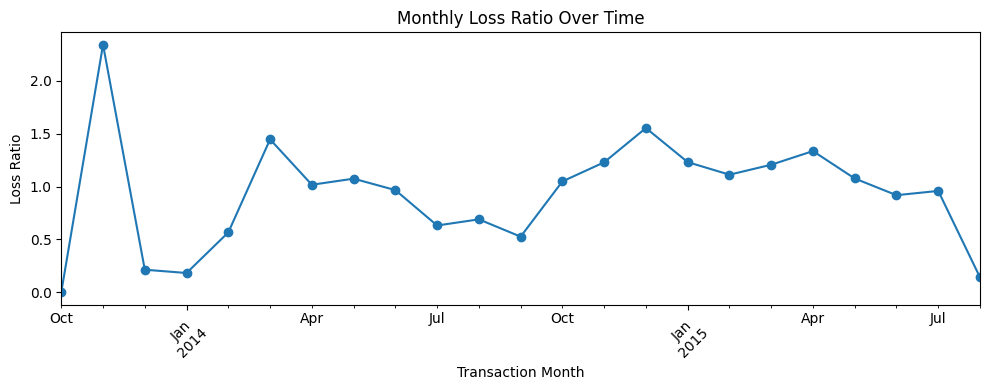

<Figure size 1000x400 with 0 Axes>

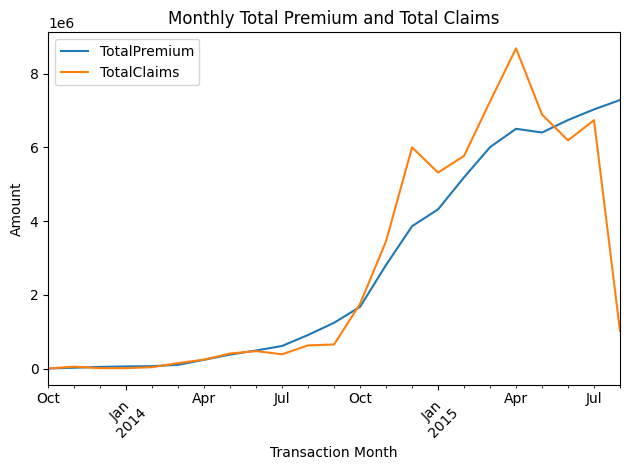

In [30]:
# ===============================================
# 9. Temporal trends over the 18-month time frame
# ===============================================

# Group by TransactionMonth, aggregating total premium & claims
monthly = df_lr.groupby("TransactionMonth")[["TotalPremium", "TotalClaims"]].sum()
monthly["LossRatio"] = monthly["TotalClaims"] / monthly["TotalPremium"]

print("\nMonthly premium, claims, and loss ratio:")
print(monthly.head())

# 9.1 Plot monthly loss ratio over time
plt.figure(figsize=(10, 4))
monthly["LossRatio"].plot(marker="o")
plt.title("Monthly Loss Ratio Over Time")
plt.ylabel("Loss Ratio")
plt.xlabel("Transaction Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 9.2 Plot monthly premium and claims
plt.figure(figsize=(10, 4))
monthly[["TotalPremium", "TotalClaims"]].plot()
plt.title("Monthly Total Premium and Total Claims")
plt.ylabel("Amount")
plt.xlabel("Transaction Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 8. Vehicle Make-Level Risk Analysis

We compute Loss Ratio by `make` (vehicle manufacturer), filtering out makes with very low premium volume to avoid noisy ratios.

We then examine:

- **Top 10 low-risk makes** (lowest Loss Ratio with sufficient premium volume).
- **Top 10 high-risk makes** (highest Loss Ratio with sufficient premium volume).

**Insights:**

- Makes with **high premium volume** and **low loss ratios** are potential **“good” segments**:
  - Attractive for marketing campaigns,
  - Possible candidates for premium discounts to gain market share.
- Makes with **high loss ratios** may require:
  - Tighter underwriting criteria,
  - Higher premiums,
  - Or deeper investigation into why these vehicles are more prone to claims.

This analysis is directly linked to the business goal of identifying **low-risk targets** for premium optimization.


C:\Users\Dawit\AppData\Local\Temp\ipykernel_21544\2744580857.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = df_in.groupby(group_cols)[["TotalPremium", "TotalClaims"]].sum()



Top 10 low-risk makes (by Loss Ratio, with min premium volume):
                                     TotalPremium  TotalClaims  LossRatio  \
make                                                                        
CHEVROLET                            29980.576965          0.0        0.0   
CITROEN                              16775.493574          0.0        0.0   
CHERY                                17105.927114          0.0        0.0   
GEELY                                11250.504211          0.0        0.0   
LEXUS                                12668.392193          0.0        0.0   
HUMMER                               95194.249848          0.0        0.0   
KIA                                  20993.262159          0.0        0.0   
PEUGEOT                              39626.511884          0.0        0.0   
TATA                                 24635.948596          0.0        0.0   
SCANIA                               33214.838325          0.0        0.0   

          

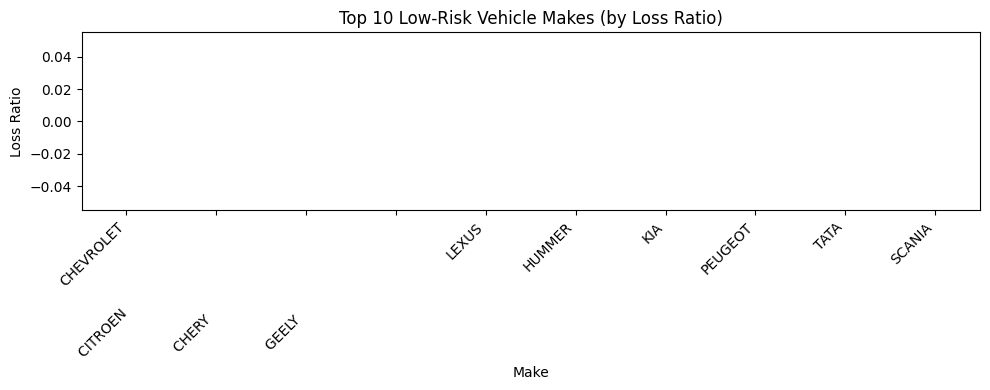

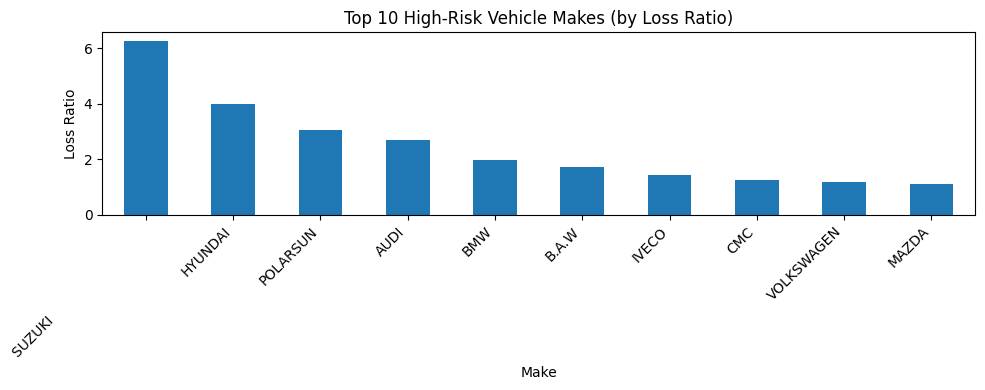

In [31]:
# ======================================
# 10. Vehicle make risk (Make-level EDA)
# ======================================

if "make" in df_lr.columns:
    make_stats = summarize_loss_ratio(df_lr, "make")

    # Filter out very small premium volumes to avoid noisy ratios
    volume_threshold = 10000  # adjust this threshold as needed
    make_stats_filtered = make_stats[make_stats["TotalPremium"] > volume_threshold]

    top_safe_makes = make_stats_filtered.sort_values("LossRatio").head(10)
    top_risky_makes = make_stats_filtered.sort_values("LossRatio", ascending=False).head(10)

    print("\nTop 10 low-risk makes (by Loss Ratio, with min premium volume):")
    print(top_safe_makes)

    print("\nTop 10 high-risk makes (by Loss Ratio, with min premium volume):")
    print(top_risky_makes)

    # Plot low-risk makes
    plt.figure(figsize=(10, 4))
    top_safe_makes["LossRatio"].plot(kind="bar")
    plt.title("Top 10 Low-Risk Vehicle Makes (by Loss Ratio)")
    plt.ylabel("Loss Ratio")
    plt.xlabel("Make")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # Plot high-risk makes
    plt.figure(figsize=(10, 4))
    top_risky_makes["LossRatio"].plot(kind="bar")
    plt.title("Top 10 High-Risk Vehicle Makes (by Loss Ratio)")
    plt.ylabel("Loss Ratio")
    plt.xlabel("Make")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

## 9. Interaction: Loss Ratio by Vehicle Type and Gender

To explore interactions between customer and vehicle characteristics, we create a heatmap of **mean Loss Ratio** by:

- Rows: `VehicleType`
- Columns: `Gender`

This visualization helps to:

- Compare risk across genders **within each vehicle type**.
- Identify specific combinations (e.g., certain vehicle types for a particular gender) that appear particularly **low-risk** or **high-risk**.

**Points to note:**

- Because many records have `Gender = "Not specified"`, results for Female vs Male should be interpreted cautiously.
- If some cells are based on very few observations, their loss ratios can be unstable.

Nevertheless, this kind of interaction view gives useful hints for potential **targeted marketing strategies** and later **hypothesis tests**.


C:\Users\Dawit\AppData\Local\Temp\ipykernel_21544\1508362083.py:7: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df_lr.pivot_table(


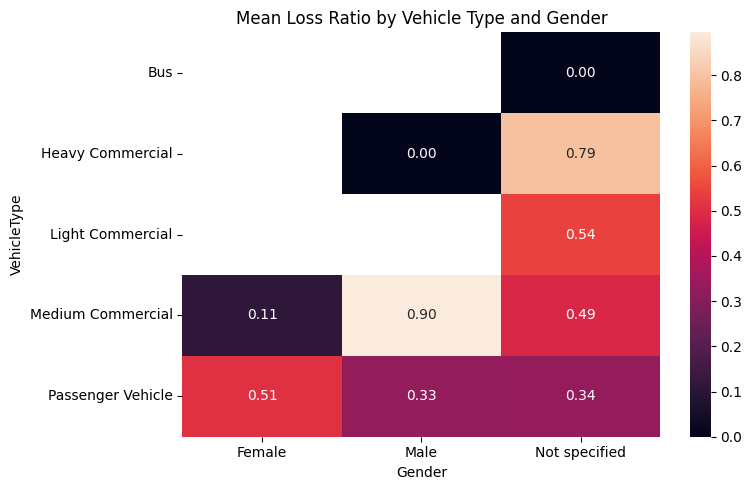


Computing monthly changes in TotalPremium and TotalClaims by PostalCode...

Head of monthly change data:
   PostalCode TransactionMonth  TotalPremium  TotalClaims  PremiumChange  \
1           1       2013-12-01   1494.352315          0.0      61.611753   
2           1       2014-01-01   1178.007368          0.0    -316.344946   
3           1       2014-02-01   1178.007368          0.0       0.000000   
4           1       2014-03-01   1140.007131          0.0     -38.000238   
5           1       2014-04-01    770.907544          0.0    -369.099587   

   ClaimsChange  
1 -50585.078947  
2      0.000000  
3      0.000000  
4      0.000000  
5      0.000000  

Correlation matrix between PremiumChange and ClaimsChange:
               PremiumChange  ClaimsChange
PremiumChange        1.00000       0.17752
ClaimsChange         0.17752       1.00000


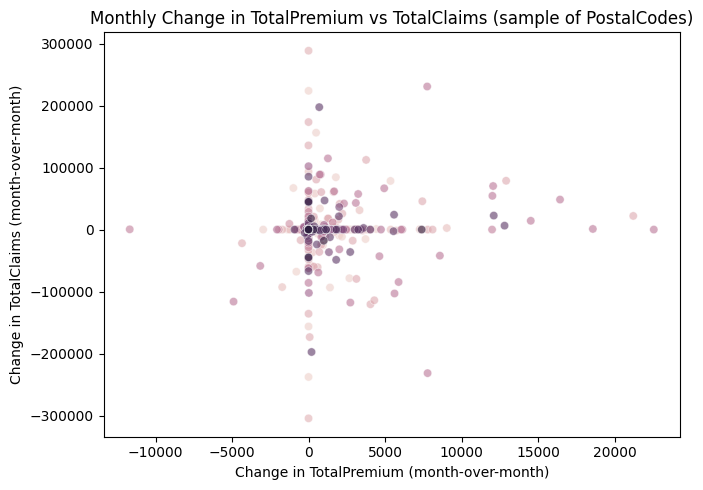


EDA complete.


In [33]:
# ==========================================================
# 11. "Creative" plot: Loss Ratio by VehicleType & Gender
# ==========================================================

if {"VehicleType", "Gender", "LossRatio"}.issubset(df_lr.columns):
    # Pivot table of mean loss ratio for each (VehicleType, Gender) combination
    pivot = df_lr.pivot_table(
        values="LossRatio",
        index="VehicleType",
        columns="Gender",
        aggfunc="mean"
    )

    plt.figure(figsize=(8, 5))
    sns.heatmap(pivot, annot=True, fmt=".2f")
    plt.title("Mean Loss Ratio by Vehicle Type and Gender")
    plt.tight_layout()
    plt.show()
# ==========================================================
# 12. Monthly changes in Premium & Claims by PostalCode
# ==========================================================

if {"PostalCode", "TransactionMonth", "TotalPremium", "TotalClaims"}.issubset(df_lr.columns):
    print("\nComputing monthly changes in TotalPremium and TotalClaims by PostalCode...")

    # Keep only rows with PostalCode
    zip_df = df_lr.dropna(subset=["PostalCode"]).copy()

    # Aggregate monthly totals per PostalCode
    zip_month = (
        zip_df
        .groupby(["PostalCode", "TransactionMonth"])[["TotalPremium", "TotalClaims"]]
        .sum()
        .reset_index()
        .sort_values(["PostalCode", "TransactionMonth"])
    )

    # Month-over-month changes per PostalCode
    zip_month[["PremiumChange", "ClaimsChange"]] = (
        zip_month
        .groupby("PostalCode")[["TotalPremium", "TotalClaims"]]
        .diff()
    )

    # Drop first-month rows per postal code where diff is NaN
    zip_month_changes = zip_month.dropna(subset=["PremiumChange", "ClaimsChange"])

    print("\nHead of monthly change data:")
    print(zip_month_changes.head())

    # Correlation between monthly changes
    corr_change = zip_month_changes[["PremiumChange", "ClaimsChange"]].corr()
    print("\nCorrelation matrix between PremiumChange and ClaimsChange:")
    print(corr_change)

    # Scatter plot for a sample of postal codes
    unique_zips = zip_month_changes["PostalCode"].dropna().unique()
    n_sample = min(100, len(unique_zips))  # limit to 100 zips for clarity
    sample_zips = np.random.choice(unique_zips, size=n_sample, replace=False)

    sample_data = zip_month_changes[zip_month_changes["PostalCode"].isin(sample_zips)]

    plt.figure(figsize=(7, 5))
    sns.scatterplot(
        data=sample_data,
        x="PremiumChange",
        y="ClaimsChange",
        hue="PostalCode",
        legend=False,
        alpha=0.6
    )
    plt.title("Monthly Change in TotalPremium vs TotalClaims (sample of PostalCodes)")
    plt.xlabel("Change in TotalPremium (month-over-month)")
    plt.ylabel("Change in TotalClaims (month-over-month)")
    plt.tight_layout()
    plt.show()
# ============================
# 13. EDA script end
# ============================

print("\nEDA complete.")
